In [1]:
import os, sys

import numpy as np

from keras.models import Model

from keras.layers import Input, Dense, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Embedding

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences

from keras.utils import to_categorical

from pandas import DataFrame, concat, read_csv

from keras.models import Sequential
from keras.layers import Dense, LSTM 

from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from sklearn.metrics import mean_squared_error
import nltk
from nltk.corpus import stopwords
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

C:\Users\panch\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras.preprocessing.text import text_to_word_sequence

# Load the Data

In [3]:
# Change directory
path = os.getcwd() 
os.chdir( path )

In [4]:
train_data = read_csv('train-1546603042473.csv')

In [5]:
test_data = read_csv('test-1546603743049.csv')

In [6]:
print (train_data.head())

              categories                                           converse
0  QUERIES FROM PHARMACY  please to verify instructions for drugname pat...
1        NEW APPOINTMENT  lmovm for patients mother to and schd rov trac...
2                 OTHERS  labtype and insurance approval other incoming ...
3                 OTHERS  clinical list changes medfusion secure electro...
4     MEDICATION RELATED  wants to wean off medication work phone name d...


In [7]:
print (train_data.tail())

               categories                                           converse
48694              OTHERS  fyi name spouse other spouse to ask what infom...
48695              REFILL  strattera name patient prescription refill str...
48696              REFILL  Rx request aricept mg rxrf medfusion secure el...
48697     NEW APPOINTMENT  patients wants to know if she can be worked in...
48698  MEDICATION RELATED  sudden aphasia and trouble walking significant...


In [8]:
print (test_data.head())

   id                                           converse
0   1  request to speak with rn no given patients ref...
1   2  patients husband ret name spouse for other pat...
2   3  fyi in his szs mom other he has an appointment...
3   4  Rx refill drugname from pharmacy name reason f...
4   5  need more time for testing dad is requesting a...


In [9]:
print (test_data.tail())

        id                                           converse
8576  8577  duopa qs next rov please earlier if needed pat...
8577  8578  patient will have mom cb to schedule rov jcg m...
8578  8579  ha injection rathke patients patient patients ...
8579  8580  faxed to wmc neurosych faxed demographics insu...
8580  8581  patient appointment name mom for need other pa...


# check for NA values

In [10]:
train_data.isnull().sum()

categories     0
converse      32
dtype: int64

In [11]:
#print NA values
train_data[train_data.isnull().any(axis=1)]

,categories,converse
1221,OTHERS,NaN
1632,OTHERS,NaN
4349,OTHERS,NaN
5096,OTHERS,NaN
5808,OTHERS,NaN
5816,JUNK,NaN
9426,JUNK,NaN
11080,OTHERS,NaN
14037,OTHERS,NaN
15549,JUNK,NaN


#  Preparing the text data

In [12]:
train_data.dropna(axis=0, inplace=True)
train_data.isnull().sum()

categories    0
converse      0
dtype: int64

In [13]:
test_data.isnull().sum()
#print NA values
test_data[test_data.isnull().any(axis=1)]

,id,converse
1072,1073,NaN
1415,1416,NaN
2971,2972,NaN
3245,3246,NaN


In [14]:
# coverting NAN to str nan, and to make row as type str
test_data.converse=test_data.converse.astype(str)

In [15]:
train_data.converse=train_data.converse.astype(str)

In [16]:
test_data.isnull().sum()

id          0
converse    0
dtype: int64

In [17]:
train_data.shape

(48667, 2)

In [18]:
test_data.shape

(8581, 2)

In [19]:
num_labels = len(set(train_data['categories']))
num_labels

21

In [20]:
# #Remove stop words
# from nltk.corpus import stopwords
# stop = stopwords.words('english')
# train_data['converse'] = train_data['converse'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
# train_data['converse'].head()

In [21]:
train_data.shape

(48667, 2)

# splitting data into train and test

In [22]:
train_size = int(len(train_data) * .8)
train_converse = train_data['converse'][:train_size]
train_categories = train_data['categories'][:train_size]
test_converse = train_data['converse'][train_size:]
test_categories = train_data['categories'][train_size:]

In [23]:
train_converse.head()

0    please to verify instructions for drugname pat...
1    lmovm for patients mother to and schd rov trac...
2    labtype and insurance approval other incoming ...
3    clinical list changes medfusion secure electro...
4    wants to wean off medication work phone name d...
Name: converse, dtype: object

In [24]:
train_size

38933

# Integer encode of text

In [25]:
vocab_size = 1000
t = Tokenizer(num_words=vocab_size)
t.fit_on_texts(train_converse)

In [26]:
print(t.document_count)

38933


In [27]:
# matrix
x_train = t.texts_to_matrix(train_converse)

In [28]:
#validation data
x_test = t.texts_to_matrix(test_converse)

In [29]:
len(x_test)

9734

In [30]:
len(x_train)

38933

In [31]:
#test data
x_test_new = t.texts_to_matrix(test_data['converse'])

In [32]:
len(x_test_new)

8581

# Processing output labels

In [33]:
##dummyfy the labels
encoder = LabelBinarizer()
encoder.fit(train_categories)
y_train = encoder.transform(train_categories)
y_test = encoder.transform(test_categories)

In [34]:
print(len(y_train))

38933


In [35]:
print(len(y_test))

9734


In [36]:
len(y_train[1])

21

In [37]:
len(x_train[1])

1000

# Building the model

In [38]:
#Neural Network
model = Sequential()

In [39]:
model.add(Dense(350, input_shape=(vocab_size,) , activation='relu'))

In [40]:
model.add(Dense(num_labels,activation='softmax'))

# Training and evaluating the model

In [41]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam',   ## 'sgd', 'rmsprop', adam
              metrics=['accuracy'])

In [42]:
batch_size = 10

In [43]:
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=2, 
                    verbose=1, 
                    validation_split=0.1)

Train on 35039 samples, validate on 3894 samples
Epoch 1/2
35039/35039 [==============================] - 40s 1ms/step - loss: 0.9834 - acc: 0.6840 - val_loss: 0.8465 - val_acc: 0.7070
Epoch 2/2
35039/35039 [==============================] - 40s 1ms/step - loss: 0.7044 - acc: 0.7524 - val_loss: 0.8742 - val_acc: 0.7057


In [44]:
# summarize the model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 350)               350350    
_________________________________________________________________
dense_2 (Dense)              (None, 21)                7371      
Total params: 357,721
Trainable params: 357,721
Non-trainable params: 0
_________________________________________________________________
None


In [45]:
score = model.evaluate(x_test, y_test, 
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

9734/9734 [==============================] - 1s 140us/step
Test score: 0.8993703656163405
Test accuracy: 0.7073145689435483


# Generating predictions

In [46]:
for i in range(5):    
    prediction = model.predict(np.array([x_test[i]]))
    text_labels = encoder.classes_ 
    predicted_label = text_labels[np.argmax(prediction[0])]
    print(test_converse.iloc[i][:50], "...")    
    print('Actual label:' + test_categories.iloc[i])
    print("Predicted label: " + predicted_label)
    print("==============================")

lvmtcb to confirm appointment ...
Actual label:OTHERS
Predicted label: OTHERS
patients order faxed other new patients order alon ...
Actual label:SHARING OF HEALTH RECORDS (FAX, E-MAIL, ETC.)
Predicted label: SHARING OF LAB RECORDS (FAX, E-MAIL, ETC.)
patients returned phone patient other patients ret ...
Actual label:PROVIDER
Predicted label: NEW APPOINTMENT
need to schedule sleep rov appointment name patien ...
Actual label:NEW APPOINTMENT
Predicted label: NEW APPOINTMENT
Rx refill request patient prescription refill fent ...
Actual label:REFILL
Predicted label: REFILL


In [47]:
len(prediction[0])

21

In [48]:
Y_pred = model.predict(x_test_new)

In [49]:
y_pred =[]
for i in Y_pred:
    text_labels = encoder.classes_     
    y_pred.append(text_labels[np.argmax(i)])

In [50]:
print(len(y_pred))

8581


In [51]:
id_list = list(range(1,len(y_pred)+1))
print(len(id_list))
labels=['id']
sample_out = pd.DataFrame( id_list, columns=labels)

8581


In [52]:
sample_out['categories']=y_pred

In [53]:
sample_out.head()

,id,categories
0,1,MEDICATION RELATED
1,2,NEW APPOINTMENT
2,3,MEDICATION RELATED
3,4,QUERIES FROM PHARMACY
4,5,MEDICATION RELATED


In [54]:
sample_out.tail()

,id,categories
8576,8577,NEW APPOINTMENT
8577,8578,PROVIDER
8578,8579,MEDICATION RELATED
8579,8580,"SHARING OF HEALTH RECORDS (FAX, E-MAIL, ETC.)"
8580,8581,"SHARING OF HEALTH RECORDS (FAX, E-MAIL, ETC.)"


In [55]:
Y_pred_test = model.predict(x_test)
y_pred_test =[]
for i in Y_pred_test:
    text_labels = encoder.classes_     
    y_pred_test.append(text_labels[np.argmax(i)])
print(len(y_pred_test))

9734


In [56]:
class_names=train_data.categories
class_names = set(class_names)

In [57]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_categories, y_pred_test)
np.set_printoptions(precision=2)

In [58]:
cnf_matrix.shape

(21, 21)

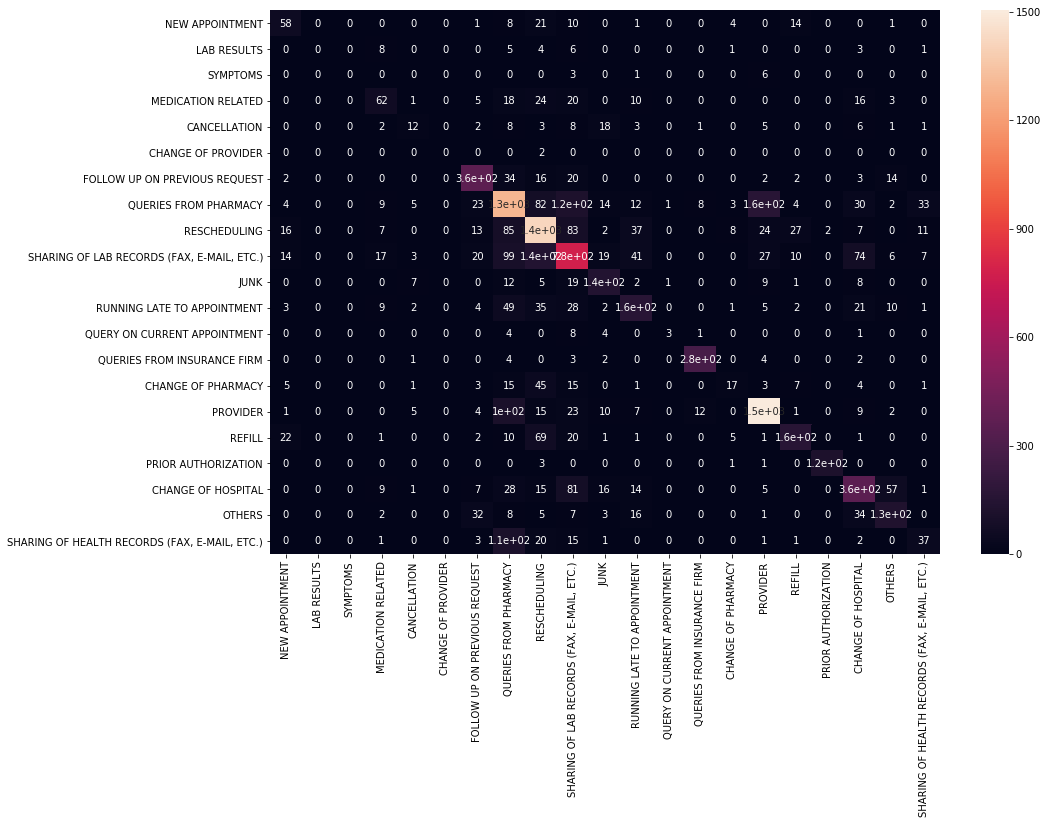

In [59]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cnf_matrix, index = [i for i in class_names],
                  columns = [i for i in class_names])
plt.figure(figsize = (15,10))
sn.heatmap(df_cm, annot=True)

# writing to CSV

In [60]:
sample_out.to_csv('predictions-1546603763008.csv', index=False)